# Binary Classification with CNNs: pneumonia_MNIST Data Set

## Setup

In [7]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import datetime

notebook_start_time = datetime.datetime.now()

In [11]:
# load the dataset
import tensorflow_datasets as tfds
train_ds, validation_ds, test_ds = tfds.load('pneumonia_mnist', split=['train', 'val', 'test'], as_supervised=True)

batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

epochs = 10

# images are batched, so we need to extract them
y_true = tf.concat([y for x, y in test_ds], axis=0)

2025-04-28 17:01:46.417995: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
def summary_graphics(history, model):
    y_pred = np.round(model.predict(test_ds))
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 5)
    ax = ax.flatten()

    # true/false positive/negative rates (better than accuracy for imbalanced data!)
    ax[0].plot(history.history['tp'], label = 'True Positives', color='g')
    #ax[0].plot(history.history['fp'], label = 'False Positives')
    ax[0].plot(history.history['tn'], label = 'True Negatives', color='r')
    #ax[0].plot(history.history['fn'], label = 'False Negatives', color='orange')
    ax[0].grid(True)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Metric Value')
    ax[0].legend(loc='right')
    ax[0].set_title('True Positive and True Negative Rates')

    # loss
    ax[1].plot(history.history['loss'], label='Loss')
    ax[1].plot(history.history['val_loss'], label = 'Val Loss')
    ax[1].grid(True)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')
    ax[2].xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].set_title('Confusion Matrix')

    plt.show()

def plot_confusion_matrix(y_true, X_test, model, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(classes))
    cm = cm.numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def get_class_training_weights(assignments, normalize=True):
    # my normal function doesn't work with the tf.data.Dataset object, so I'm writing a new one
    weight_1 = sum(assignments) / len(assignments)
    weight_0 = 1 - weight_1
    if normalize:
        denom = max(weight_1, weight_0)
        weight_1 = weight_1 / denom
        weight_0 = weight_0 / denom
    return {0: weight_0, 1: weight_1}


In [ ]:
class_weight = get_class_training_weights(tf.concat([y for x, y in train_ds], axis=0))

print(f"Weight for normal class: {class_weight[0]:1.3f}")
print(f"Weight for pneumonia class: {class_weight[1]:1.3f}")

2025-04-28 16:59:25.532191: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Weight for normal class: 0.347
Weight for pneumonia class: 1.000


## Training

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((28, 28, 1), name="input"),
    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(1000, activation='relu', name="5.2dense"),
    tf.keras.layers.Dense(500, activation='relu', name="5.4dense"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_1")

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

model_1.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 5.1flatten (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.2dense (Dense)                │ (None, 1000)           │       785,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.4dense (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,286,001 (4.91 MB)

 Trainable params: 1,286,001 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model_1.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10


148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8113 - loss: 9.3127 - precision: 0.8330 - recall: 0.9220 - tn: 344.0403 - tp: 1674.3826 - val_accuracy: 0.9351 - val_loss: 1.0005 - val_precision: 0.9298 - val_recall: 0.9871 - val_tn: 106.0000 - val_tp: 384.0000
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8906 - loss: 1.1706 - precision: 0.8970 - recall: 0.9630 - tn: 411.5973 - tp: 1705.7719 - val_accuracy: 0.9485 - val_loss: 0.8560 - val_precision: 0.9763 - val_recall: 0.9537 - val_tn: 126.0000 - val_tp: 371.0000
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9116 - loss: 0.8832 - precision: 0.9189 - recall: 0.9664 - tn: 448.2416 - tp: 1713.1879 - val_accuracy: 0.9351 - val_loss: 1.0294 - val_precision: 0.9784 - val_recall: 0.9332 - val_tn: 127.0000 - val_tp: 363.0000
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9209 - loss: 0.7102 - precision: 0.9289 - recall: 0.9676 - tn: 474.6309 - tp: 1721.0134 - val_accuracy: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


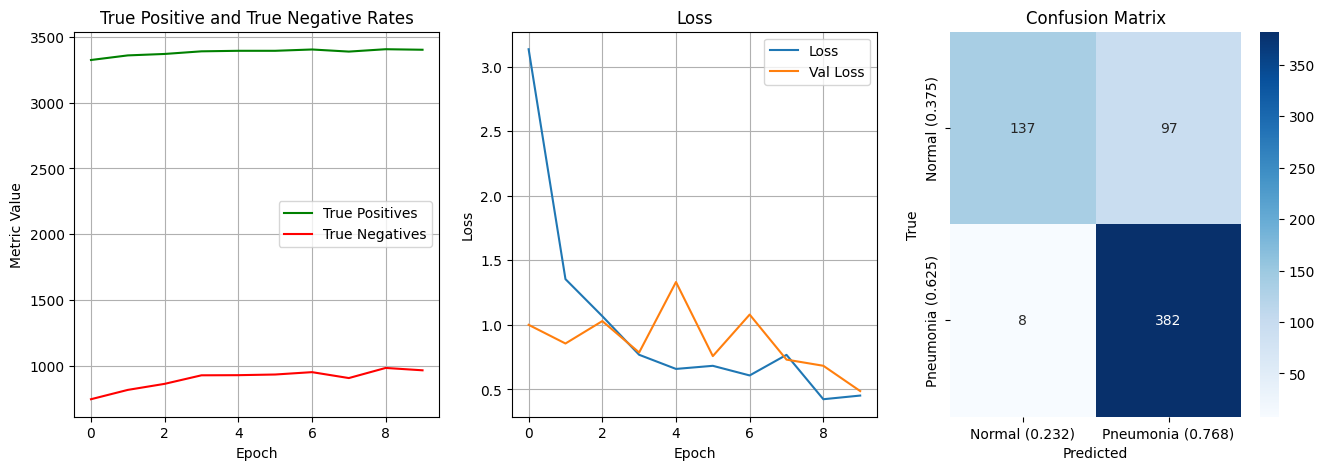

In [67]:
summary_graphics(history, model_1)

In [ ]:
# try something similar to xception, but with fewer filters and layers
# to account for how small these images are
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((28, 28, 1), name="input"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    #tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="1.3pool"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="2.3pool"),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name='3.4pool'),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="4.6pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(512, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(256, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.5, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_2")

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

model_2.summary()

Model: "Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 0.1rflip (RandomFlip)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.2rrot (RandomRotation)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.3rtran (RandomTranslation)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.1conv (Conv2D)                │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (Conv2D)                │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (Conv2D)                │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 7, 7, 64)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2batchnorm                    │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 7, 7, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1conv (SeparableConv2D)       │ (None, 4, 4, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2batchnorm                    │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.3conv (SeparableConv2D)       │ (None, 4, 4, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.6pool (MaxPooling2D)          │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.1flatten (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.2dense (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.3dropout (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.4dense (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.5dropout (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           25

 Total params: 296,657 (1.13 MB)

 Trainable params: 296,401 (1.13 MB)

 Non-trainable params: 256 (1.00 KB)

In [70]:
history = model_2.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7252 - loss: 0.4531 - precision: 0.7403 - recall: 0.9663 - tn: 9.9597 - tp: 1752.6107 - val_accuracy: 0.7424 - val_loss: 0.6254 - val_precision: 0.7424 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 389.0000
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7389 - loss: 0.2685 - precision: 0.7389 - recall: 1.0000 - tn: 0.0000e+00 - tp: 1776.4698 - val_accuracy: 0.7424 - val_loss: 0.6332 - val_precision: 0.7424 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 389.0000
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7665 - loss: 0.1649 - precision: 0.7637 - recall: 0.9919 - tn: 111.8054 - tp: 1757.5033 - val_accuracy: 0.7385 - val_loss: 0.6547 - val_precision: 0.9961 - val_recall: 0.6504 - val_tn: 134.0000 - val_tp: 253.0000
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8650 - loss: 0.1476 - precision: 0.8636 - recall: 0.9707 - tn: 349.2550 - tp: 1720.5100 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


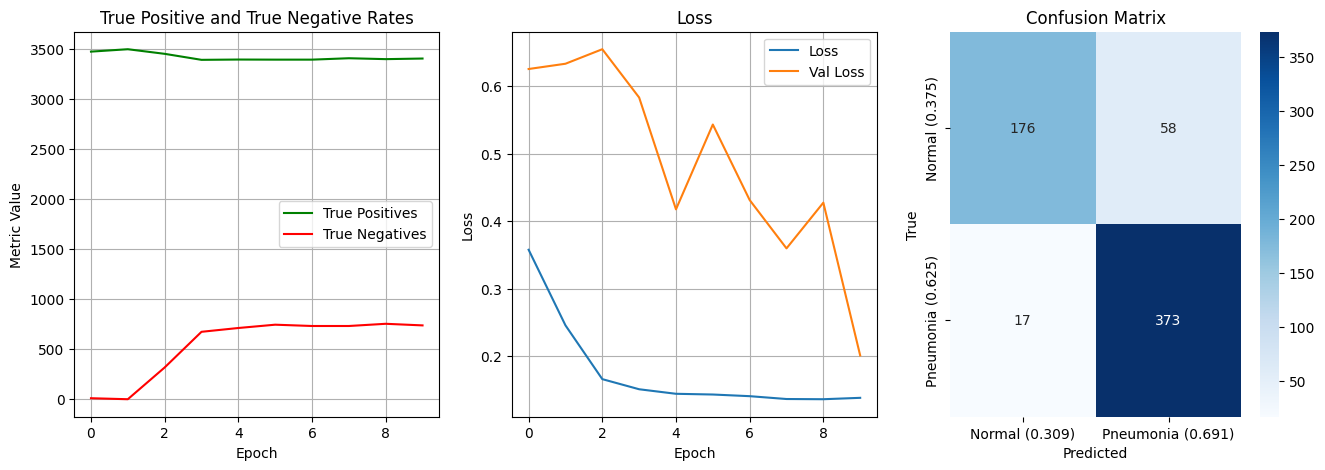

In [71]:
summary_graphics(history, model_2)

In [14]:
# model accuracy seems to be capping out, so let's lower dropout slightly
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((28, 28, 1), name="input"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    #tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="1.3pool"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="2.3pool"),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name='3.4pool'),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same', name="4.6pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(512, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.5, name="5.3dropout"),
    tf.keras.layers.Dense(256, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.4, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_3")

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.7331 - loss: 0.4390 - precision: 0.7382 - recall: 0.9886 - tn: 2.0000 - tp: 1769.4698 - val_accuracy: 0.7424 - val_loss: 0.6221 - val_precision: 0.7424 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 389.0000
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7389 - loss: 0.2735 - precision: 0.7389 - recall: 1.0000 - tn: 0.0000e+00 - tp: 1776.4698 - val_accuracy: 0.7424 - val_loss: 0.6206 - val_precision: 0.7424 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 389.0000
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7730 - loss: 0.1740 - precision: 0.7679 - recall: 0.9947 - tn: 128.2081 - tp: 1762.6376 - val_accuracy: 0.5611 - val_loss: 0.6762 - val_precision: 1.0000 - val_recall: 0.4087 - val_tn: 135.0000 - val_tp: 159.0000
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8508 - loss: 0.1555 - precision: 0.8510 - recall: 0.9675 - tn: 327.7450 - tp: 1718.1007 

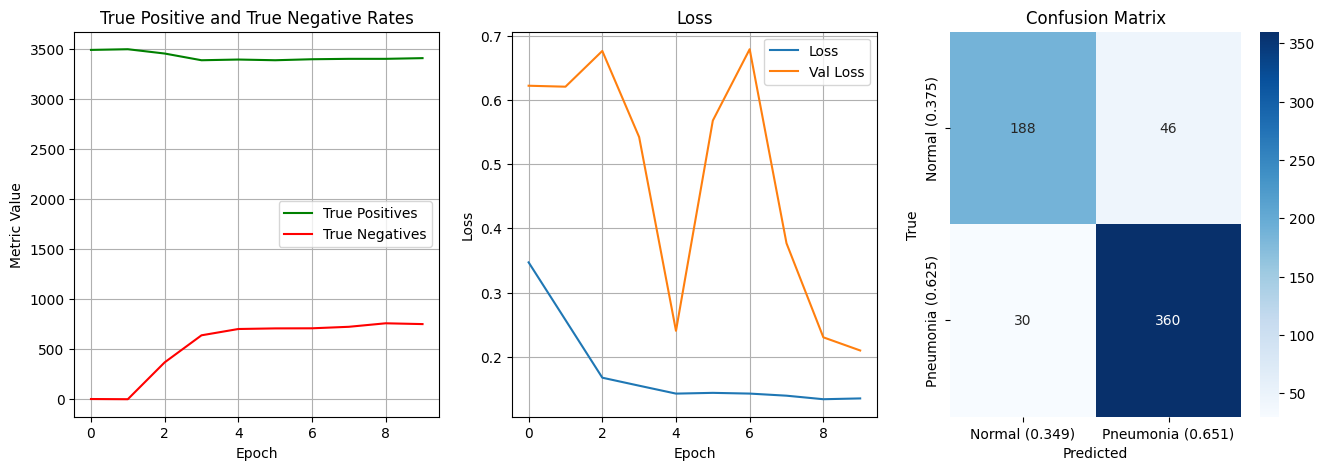

In [15]:
history = model_3.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)
summary_graphics(history, model_3)

Epoch 1/20
  1/148 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8125 - loss: 0.1442 - precision: 0.8000 - recall: 0.9524 - tn: 6.0000 - tp: 20.0000

148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8837 - loss: 0.1347 - precision: 0.8828 - recall: 0.9717 - tn: 390.8121 - tp: 1727.3356 - val_accuracy: 0.8626 - val_loss: 0.3041 - val_precision: 0.9969 - val_recall: 0.8175 - val_tn: 134.0000 - val_tp: 318.0000
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8906 - loss: 0.1273 - precision: 0.8903 - recall: 0.9716 - tn: 402.4094 - tp: 1726.9329 - val_accuracy: 0.8340 - val_loss: 0.3362 - val_precision: 1.0000 - val_recall: 0.7763 - val_tn: 135.0000 - val_tp: 302.0000
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8930 - loss: 0.1297 - precision: 0.8909 - recall: 0.9746 - tn: 402.8054 - tp: 1730.1141 - val_accuracy: 0.9237 - val_loss: 0.1831 - val_precision: 0.9604 - val_recall: 0.9357 - val_tn: 120.0000 - val_tp: 364.0000
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8851 - loss: 0.1250 - precision: 0.8834 - recall: 0.9728 - tn: 394.4027 - tp: 1728.6107 - val_accuracy: 

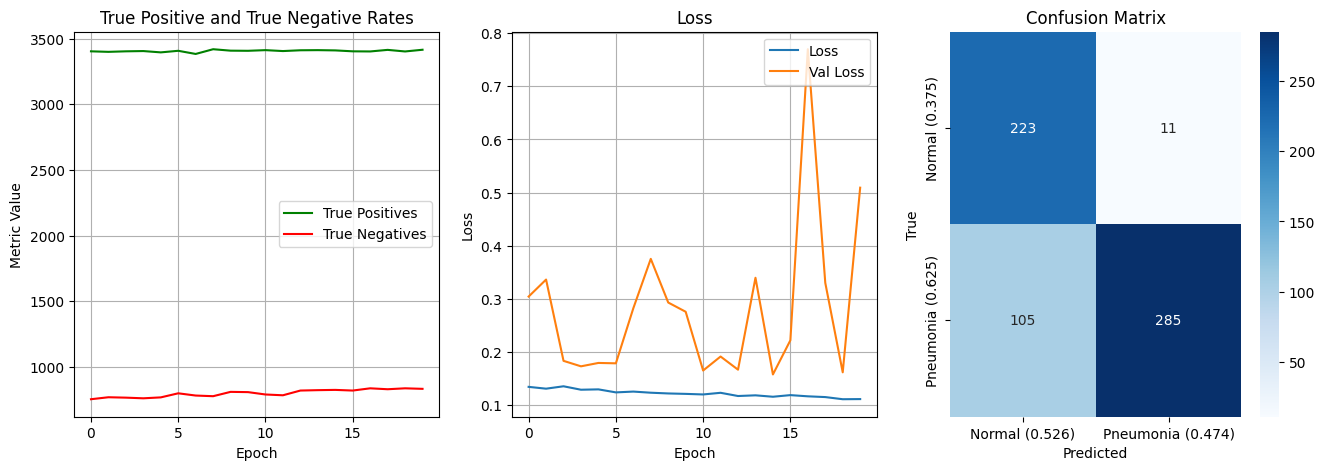

In [16]:
# maybe more epochs will help
epochs = 20
history = model_3.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)
summary_graphics(history, model_3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


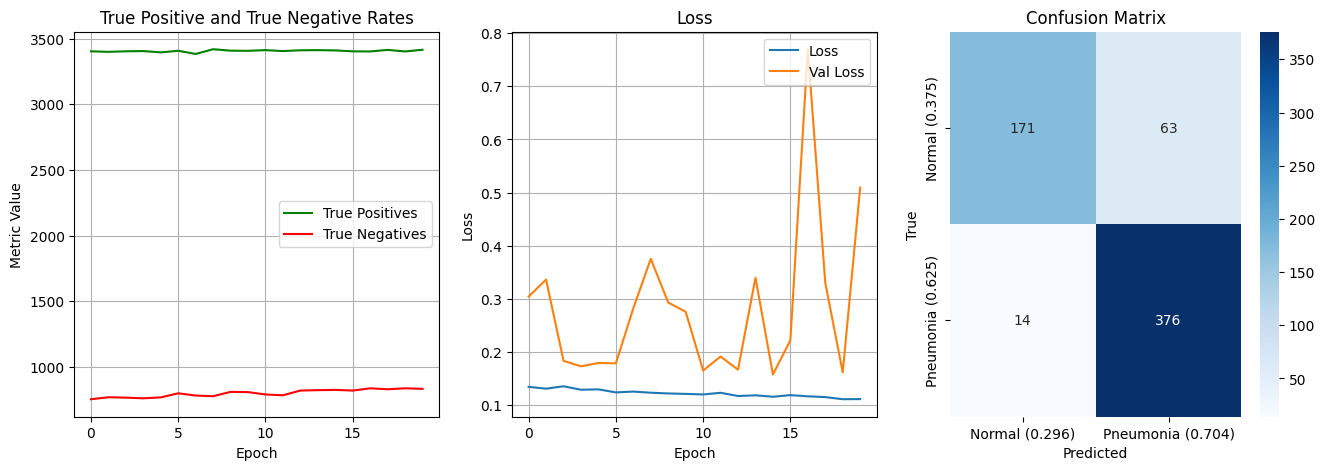

In [19]:
best_model = tf.keras.models.load_model('best_model.keras')
summary_graphics(history, best_model)

In [18]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-04-28 17:08:26.511550 (duration: 0:07:24.855050)
